### Optical pulse broadening in optical fiber

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift, ifft
from scipy.constants import c
from scipy import signal

def propagate(phase1, phase2, Ein=np.array([[1],[0]])):

    propagatematrix1 = np.array([[np.exp(1j*phase1),0],[0,np.exp(1j*phase2)]]);

    Eout = np.dot(propagatematrix1,Ein)
    
    return Eout


def beamsplitter(PT,Ein):

   # See Wikipedia for details. https://en.wikipedia.org/wiki/Beam_splitter       

   # Dielectric type Beam Splitter
     #phiT = 0
     #phiR = 0
     #phiO = 0

   # Symmetric type Beam Splitter
     phiT = 0
     phiR = -0.5 * np.pi    
     phiO = 0.5 * np.pi
     
     T = np.sqrt(PT) # Transmission defined as Electric field

     PR = 1-PT 

     R = np.sqrt(PR) # Reflection defined as Electric field

     Theta1 = np.arctan(R/T) # Split Raio in Radian   
         
     BSmatrix1 = np.dot(np.exp(1J*phiO),np.array([[np.sin(Theta1)*np.exp(1J*phiR),np.cos(Theta1)*np.exp(-1J*phiT)],[np.cos(Theta1)*np.exp(1j*phiT),-1*np.sin(Theta1)*np.exp(-1J*phiR)]]))
     
     Eout = np.dot(BSmatrix1, Ein)

     return Eout

samplerate: 262144
N: 524288
t_step: 2e-16
frequencystep:  9536743164.0
frequencystep:  9.53674E+09
Nyq_freq: 2.50000E+15
Shape of Optical Frequencies: (262144,)
Optical Frequency1: lightfreq1 [Hz] 5.62950E+14
Optical Frequency2: lightfreq2 [Hz] 5.62950E+14
Difference Frequency: freq_diff [Hz] 0.00000E+00


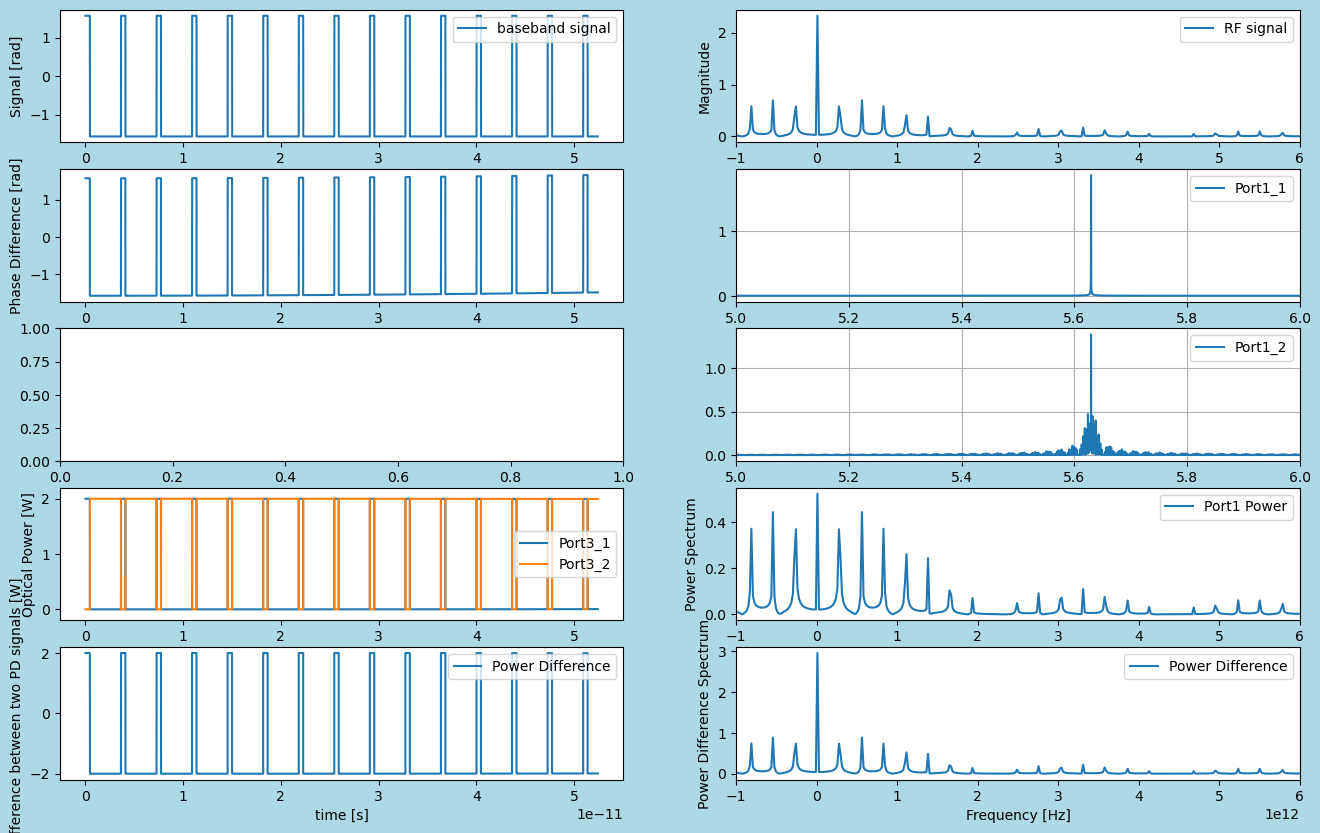

In [72]:
samplerate = 2**18 # Number of Points
print('samplerate:', samplerate)

N = 2* samplerate
print('N:', N)

t_step = 2e-16 #[s]
print('t_step:', t_step)
tcol = np.linspace(0.0, t_step * samplerate, samplerate, endpoint=False)

frequencystep = (1/t_step) // N
print("frequencystep: ", frequencystep)
print("frequencystep: ", f'{frequencystep:.5E}')

Nyq_freq = samplerate * frequencystep
print('Nyq_freq:', f'{Nyq_freq:.5E}')

optical_frequencies = np.linspace(-Nyq_freq, Nyq_freq, samplerate)
print('Shape of Optical Frequencies:',optical_frequencies.shape)

amp_c = 0.5 * np.pi

freq_rf = 2**38 # 2**38 = 275 e9

#duty_ratio = 0.0625
duty_ratio = 0.125
#duty_ratio = 0.25

md = 1 # modulation depth. 1 = 100 %
dc_offset = 0 # DC offset

#Sine
#rfsignalcol = amp_c * np.sin(2 * np.pi * freq_rf * tcol) + dc_offset #[rad]

#Square
baseband_signals= amp_c *signal.square(2 * np.pi * freq_rf * tcol, duty_ratio) +dc_offset #[rad] 

#prbs
#rfsignalcol = prbs_1(samplerate, a1_range = [0,1], b1_range = [10, 50]) # too long time
#rfsignalcol = prbs_2(samplerate, numberofpointspersymbol = 2 ** 6)

no = 1 # Refractive Index of medium

drift_wl2_mag = 0.001
drift_wl2_freq = 2 ** 20

oplcommon1=1 #Common Path Length 1
oplcommon2=1 #Common Path Length 2

opl1 =1
opl2= 1

# If opticalfreq1 and opticalfreq2 are equal, homodyne. If not, heterodyne.

opticalfreq1 = 2 ** 49
print("Optical Frequency1: lightfreq1 [Hz]",f'{opticalfreq1:.5E}')

opticalfreq2 = 2 ** 49
print("Optical Frequency2: lightfreq2 [Hz]",f'{opticalfreq2:.5E}')

freq_diff = opticalfreq1-opticalfreq2
print("Difference Frequency: freq_diff [Hz]",f'{freq_diff:.5E}')

PT1 = 0.5 # PT: Power Transmission of Beam splitter

# Define Input Electric Field:

#Ein1 = np.array([[1+0j],[1-0j]]) 
Ein1 = np.array([[0.707+0.707j],[-0.707-0.707j]])
#Ein1 = np.array([[1 + 0j],[-1 - 0j]])

#phase1_col = np.zeros(samplerate)
#phase2_col = np.zeros(samplerate)
phase_diff_col = np.zeros(samplerate)
Port1_1_EFcol = np.zeros(samplerate, dtype=complex)
Port1_2_EFcol = np.zeros(samplerate, dtype=complex)
Port3_1_EFcol = np.zeros(samplerate,dtype=complex)
Port3_2_EFcol = np.zeros(samplerate, dtype=complex)
Port3_1_powercol = np.zeros(samplerate)
Port3_2_powercol = np.zeros(samplerate)
Power_diffcol = np.zeros(samplerate)

for ii in range(samplerate):
    
    t = tcol[ii]
    baseband_signal = baseband_signals[ii]
    
    #amp_c * np.sin(2 * np.pi * freq_rf * t) + dc_offset #[rad]
    #rfsignalcol[ii] = rf_signal  
    
    # Path Length modulated

    phase1 = 2*np.pi * opticalfreq1 * t # phase of local oscillator [rad]
    #phase1_col[ii] = phase1

    #phase2 = 2*np.pi * lightfreq2 * t # Phase of Continious Wave [rad]
    phase2 = 2*np.pi * (opticalfreq2 + drift_wl2_mag* drift_wl2_freq*ii)* t + baseband_signal # Phase of Modulated Light [rad]
    #phase2_col[ii] = phase2
    phase_diff_col[ii] = phase2 - phase1

    Eout1 = propagate(phase1, phase2, Ein1)
    
    Port1_1_Eout = Eout1[0,0] # Modulated Light signal
    Port1_1_EFcol[ii] = Port1_1_Eout
    
    Port1_2_Eout = Eout1[1,0] # Local Oscillator
    Port1_2_EFcol[ii] = Port1_2_Eout

    Ein2 = Eout1

    Eout2 = beamsplitter(PT1, Ein2)
    Ein3 = Eout2    
   
    Eout3 = propagate(1, 1, Ein3)
    
    #Trans
    Port3_1_Eout = Eout3[0,0]
    Port3_1_EFcol[ii] = Port3_1_Eout

    power3_1 = (np.abs(Port3_1_Eout))**2 # Optical power is calculated as squared of absolute electric field strength
    Port3_1_powercol[ii] = power3_1

    #Reflect
    Port3_2_Eout = Eout3[1,0] 
    Port3_2_EFcol[ii] = Port3_2_Eout

    power3_2 = (np.abs(Port3_2_Eout))**2
    Port3_2_powercol[ii] = power3_2
    
    # Power Difference
    Power_diff = power3_1 - power3_2
    Power_diffcol[ii] = Power_diff
 
fig1 = plt.figure(figsize = (16,10), facecolor='lightblue')
ax1_1 = fig1.add_subplot(5, 2, 1)
ax1_2 = fig1.add_subplot(5, 2, 2)
ax1_3 = fig1.add_subplot(5, 2, 3)
ax1_4 = fig1.add_subplot(5, 2, 4)
ax1_5 = fig1.add_subplot(5, 2, 5)
ax1_6 = fig1.add_subplot(5, 2, 6)
ax1_7 = fig1.add_subplot(5, 2, 7)
ax1_8 = fig1.add_subplot(5, 2, 8)
ax1_9 = fig1.add_subplot(5, 2, 9)
ax1_10 = fig1.add_subplot(5, 2, 10)

ax1_1.plot(tcol,baseband_signals,label="baseband signal")
ax1_1.set_ylabel("Signal [rad]")
ax1_1.legend()

#xf = fftshift(fftfreq(tcol.shape[-1]))
#xf = optical_frequencies

#xf = fftfreq(samplerate, t_step)[:samplerate//2]

fft_baseband_signals = fftshift(fft(baseband_signals))

#ax1_2.plot(xf, 2.0/samplerate * np.abs(rfsignal_powercol_fft[0:samplerate//2]), label="RF signal")
ax1_2.plot(optical_frequencies, 2.0/samplerate * np.abs(fft_baseband_signals), label="RF signal")

ax1_2.set_xlabel("Frequency [Hz]")
ax1_2.set_ylabel("Magnitude")
ax1_2.set_xlim(-1e12,6e12)
ax1_2.legend()

#ax1_3.plot(tcol,np.real(Port1_1_EFcol))
#ax1_3.set_ylabel("Real Part of EF")
ax1_3.plot(tcol,phase_diff_col)
ax1_3.set_ylabel("Phase Difference [rad]")

#ax1_5.plot(tcol,np.real(Port1_2_EFcol))
#ax1_5.set_ylabel("Real Part of EF")
#ax1_5.plot(tcol,phase2_col)
#ax1_5.set_ylabel("Phase2")

ax1_7.plot(tcol,Port3_1_powercol,label="Port3_1")
ax1_7.plot(tcol,Port3_2_powercol,label="Port3_2")
ax1_7.set_ylabel("Optical Power [W]")
ax1_7.set_ylim(-0.2,2.2)
ax1_7.legend()

ax1_9.plot(tcol,Power_diffcol,label="Power Difference" )
ax1_9.set_xlabel("time [s]")
ax1_9.set_ylabel("Difference between two PD signals [W]")
ax1_9.legend()

fft_Port1_1_EFcol = fftshift(fft(Port1_1_EFcol))
fft_Port1_2_EFcol = fftshift(fft(Port1_2_EFcol))

#ax1_4.plot(xf, 2.0/samplerate * np.abs(Port1_1_EFcol_f[0:samplerate//2]),label="Port1_1")
ax1_4.plot(optical_frequencies, 2.0/samplerate * np.abs(fft_Port1_1_EFcol),label="Port1_1")

ax1_4.set_xlim(500e12,600e12)
ax1_4.legend()
ax1_4.grid(True)

#ax1_6.plot(xf, 2.0/samplerate * np.abs(Port1_2_EFcol_f[0:samplerate//2]),label="Port1_2")
ax1_6.plot(optical_frequencies, 2.0/samplerate * np.abs(fft_Port1_2_EFcol),label="Port1_2")
ax1_6.set_xlim(500e12,600e12)
ax1_6.legend()
ax1_6.grid(True)

fft_Port1_powercol = fftshift(fft(Port3_1_powercol))
fft_Port2_powercol = fftshift(fft(Port3_2_powercol))

#ax1_8.plot(xf, 2.0/samplerate * np.abs(Port1_powercol_f[0:samplerate//2]),label="Port1 Power")
ax1_8.plot(optical_frequencies, 2.0/samplerate * np.abs(fft_Port1_powercol),label="Port1 Power")
ax1_8.set_ylabel("Power Spectrum")
#ax1_8.set_xlim(-1e12,6e12)

#ax1_8.plot(xf, 2.0/samplerate * np.abs(Port2_powercol_f[0:samplerate//2]), label="Port2 Power")

ax1_8.set_xlim(-1e12,6e12)
ax1_8.legend()

fft_Power_diffcol = fftshift(fft(Power_diffcol))
#ax1_10.plot(xf, 2.0/samplerate * np.abs(Power_diffcol_f[0:samplerate//2]), label="Power Difference")
ax1_10.plot(optical_frequencies, 2.0/samplerate * np.abs(fft_Power_diffcol), label="Power Difference")

ax1_10.set_xlabel("Frequency [Hz]")
ax1_10.set_ylabel("Power Difference Spectrum")
ax1_10.set_xlim(-1e12,6e12)
ax1_10.legend()


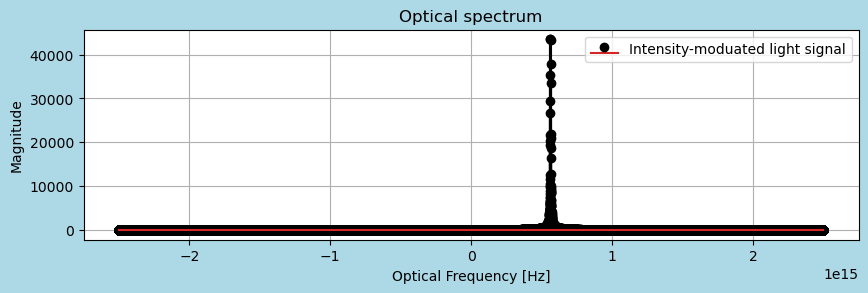

In [73]:

fft_random_analog_signal = fftshift(fft(Port3_1_EFcol))
#print('Shape of fft_random_analog_signal (Frequency Domain):', fft_random_analog_signal.shape)

fig1 = plt.figure(figsize = (10,6), facecolor='lightblue')

ax1_1 = fig1.add_subplot(2, 1, 1)
ax1_1.set_title("Optical spectrum")
ax1_1.stem(optical_frequencies, np.abs(fft_random_analog_signal),"k",label='Intensity-moduated light signal')
ax1_1.set_xlabel("Optical Frequency [Hz]")
ax1_1.set_ylabel("Magnitude")
#ax1_1.set_xlim(190e12,200e12)
#ax1_1.set_xlim(0, frequencystep * samplerate * 1.1/1)
ax1_1.legend()
ax1_1.grid()


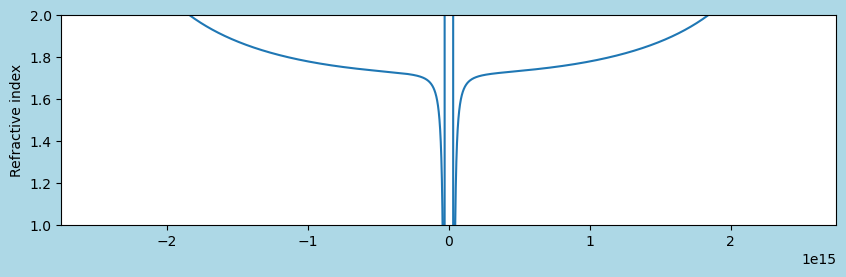

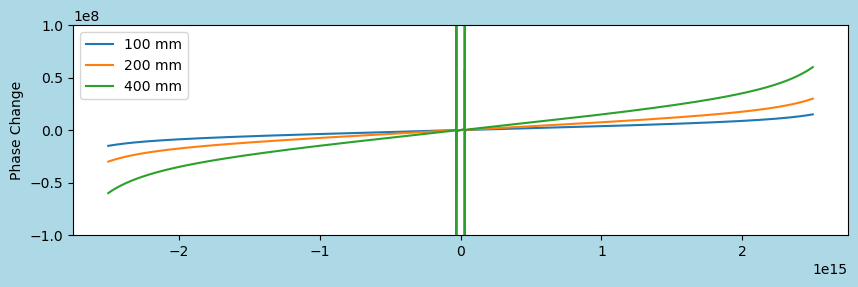

In [74]:
def indexes_quartz(o_frequencies):
    
    wavelengths = (1e6 * c)/ o_frequencies

    indexes_quartz = np.sqrt(1 + 0.708395 * wavelengths**2/(wavelengths)**2 - 0.00729) + 0.420399 * wavelengths**2/(wavelengths**2 - 0.01050) + 0.866341 * wavelengths**2/(wavelengths**2 - 97.93428)

    #indexes_quartz = np.sqrt(1 + (0.6961663 * wavelengths**2/(wavelengths)**2 - 0.00684043**2) + (0.4079426 * wavelengths**2/(wavelengths**2 - 0.1162414**2)) + (0.8974794 * wavelengths**2/(wavelengths**2 - 9.896161**2)))
  

    return indexes_quartz


# Glass parameters
indexes_quartz1 = indexes_quartz(optical_frequencies)  # Refractive index of water
thickness_100mm = 100e-3  # Thickness of water layer in meters
thickness_200mm = 200e-3  # Thickness of water layer in meters
thickness_400mm = 400e-3  # Thickness of water layer in meters

fig1 = plt.figure(figsize = (10,6), facecolor='lightblue')
ax1_1 = fig1.add_subplot(2, 1, 1)

ax1_1.plot(optical_frequencies, indexes_quartz1)
#ax1_1.set_xlim(200e12, 800e12)
ax1_1.set_ylim(1,2)
ax1_1.set_ylabel("Refractive index")

# Calculate phase change
phase_change_thickness100mm = (2 * np.pi * indexes_quartz1 * thickness_100mm) / (c/ optical_frequencies) # radian
phase_change_thickness200mm = (2 * np.pi * indexes_quartz1 * thickness_200mm) / (c/ optical_frequencies) # radian
phase_change_thickness400mm = (2 * np.pi * indexes_quartz1 * thickness_400mm) / (c/ optical_frequencies) # radian

fig2 = plt.figure(figsize = (10,6), facecolor='lightblue')
ax2_1 = fig2.add_subplot(2, 1, 1)

ax2_1.plot(optical_frequencies, phase_change_thickness100mm, label='100 mm')
ax2_1.plot(optical_frequencies, phase_change_thickness200mm, label='200 mm')
ax2_1.plot(optical_frequencies, phase_change_thickness400mm, label='400 mm')
#ax2_1.set_xlim(200e12, 800e12)
ax2_1.set_ylim(-1e8,1e8)
ax2_1.set_ylabel("Phase Change")
ax2_1.legend()


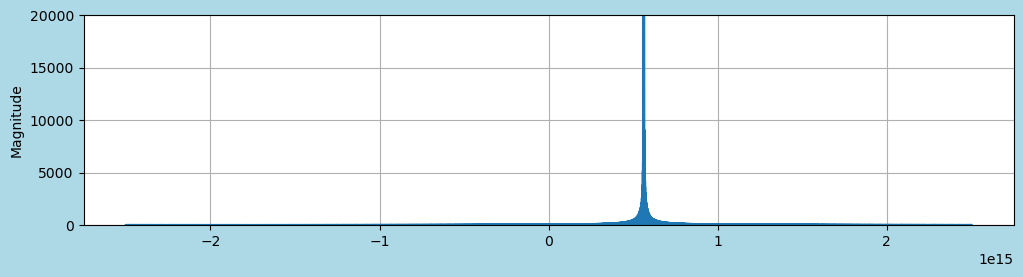

In [75]:
mag1 = np.cos(phase_change_thickness100mm) + 1j*np.sin(phase_change_thickness100mm)
mag2 = np.cos(phase_change_thickness200mm) + 1j*np.sin(phase_change_thickness200mm)
mag3 = np.cos(phase_change_thickness400mm) + 1j*np.sin(phase_change_thickness400mm)

#Y_freq = fft_random_analog_signal
Y_freq_1 = mag1 * fft_random_analog_signal
Y_freq_2 = mag2 * fft_random_analog_signal
Y_freq_3 = mag3 * fft_random_analog_signal

fig1 = plt.figure(figsize = (12,6), facecolor='lightblue')
ax1_1 = fig1.add_subplot(2, 1, 1)

ax1_1.plot(optical_frequencies, np.abs(Y_freq_1), )
ax1_1.set_ylabel('Magnitude')
#ax1_1.set_xlim(200e12, 800e12)
ax1_1.set_ylim(-1, 20000)
ax1_1.grid()


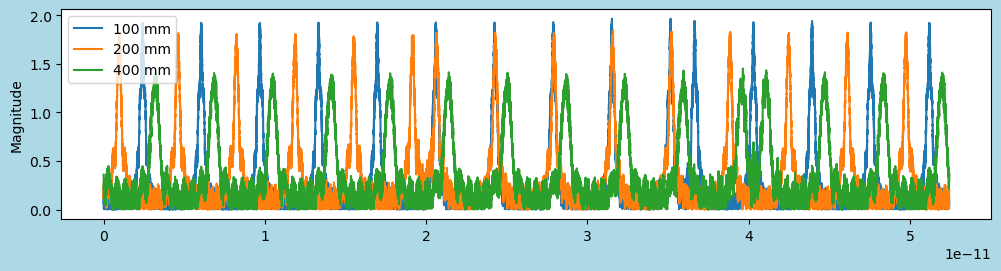

In [76]:
y_freq_1 = ifft(Y_freq_1)
y_freq_2 = ifft(Y_freq_2)
y_freq_3 = ifft(Y_freq_3)

fig2 = plt.figure(figsize = (12,6), facecolor='lightblue')
ax2_1 = fig2.add_subplot(2, 1, 1)

#ax2_1.plot(transformed_tcol, (np.abs(y_freq))**2)
ax2_1.plot(tcol, np.abs(y_freq_1),label = "100 mm")
ax2_1.plot(tcol, np.abs(y_freq_2),label = "200 mm")
ax2_1.plot(tcol, np.abs(y_freq_3),label = "400 mm")

#ax2_1.plot(tcol, np.real(y_freq))
ax2_1.set_ylabel('Magnitude')
ax2_1.legend()

In [77]:

# c = 2.99792458 * 1e8;	%m/sec
#  centerfreq = 194.05*1e12;
#  widthfreq = 1000*1e9;	%Hz

#startfreq = centerfreq - 0.5.* widthfreq
# stepfreq = widthfreq / mm; % Hz
 

#  eyezoomin = 6;
#  NRZ = 50;
#   judgevoltage = 0.5;
#   bitrate = 10e9; %1073741824	% bps;
#   timeperbit = 1/(bitrate)
#  pulsestowatch = 10;
#b = 0.0;
   
"""
[ncorecol, Ncorecol, scorecol] = sellmeiercore(wlcol)	#get index !! input wavelength as um
betacorecol = kcol* ncorecol

[ncladcol, Ncladcol, scladcol] = sellmeierclad(wlcol)	#get index !! input wavelength as um
betacladcol = kcol* ncladcol;

betacol = kcol* np.sqrt((ncladcol).^2 + ((ncorecol).^2 - (ncladcol).^2) .* b)
  
 
polyfitbeta = np.polyfit(omegacol,betacol,3) #fitting by 3rd order
betaestcol = np.polyval(polyfitbeta,omegacol)# get
 
dpolyfitbeta = np.polyder(polyfitbeta)#;%derivate
dbetadomegacol = np.polyval(dpolyfitbeta,omegacol)#;%get
 
fig4 = plt.figure(figsize = (10,6), facecolor='lightblue')
#set(fig2,'Position',[100 400 600 300])

plot(1e-12.* omegacol,1.0001e-6.* betacol,'r-',...
   1e-12.* omegacol,1e-6.* betaestcol,'g-',...
      1e-12.* omegacol,1e-6.* betacorecol,'b-',...
   1e-12.* omegacol,1e-6.* betacladcol,'y-');

xlabel('T [Hz]','FontSize',12); 	ylabel('beta [rad / m]','FontSize',9);
  
fig5 = plt.figure(figsize = (10,6), facecolor='lightblue')

#plot(1e-12.* omegacol,dbetadomegacol);
#xlabel('T','FontSize',9);  
#ylabel('dbetadomega','FontSize',9);

 polyfitdbetadomega = polyfit(omegacol,dbetadomegacol,2);%fitting
 dpolyfitbetadomega = polyder(polyfitdbetadomega);%derivate
 ddbetaddomegacol = polyval(dpolyfitbetadomega,omegacol);%get


fig5 = plt.figure(figsize = (10,6), facecolor='lightblue')

set(fig3,'Position',[320 50 500 320])
plot(1e-12.* freqcol, 1e24.* ddbetaddomegacol); 
% probably correct !! p.73 of NTT book.
xlabel('freq [THz]','FontSize',9);
ylabel('ddbetaddomega [ps^2 / m] ','FontSize',9);

 Dcol = -1.* omegacol.* ddbetaddomegacol ./ wlcol;

fig6 = plt.figure(figsize = (10,6), facecolor='lightblue')
set(fig4,'Position',[320 50 500 320])
plot(1e-12.* freqcol, 1e6.* Dcol); 
% probably correct !! p.73 of NTT book.
xlabel('freq [THz]','FontSize',9);
ylabel('D [ps/(nm*km)]','FontSize',12);


tstep = 1/(stepfreq*mm*1) # sec I think this sould be 1 !! not 2 !!!!


resolutionperpulse = timeperbit / tstep
[tcol, pulsescol] = signalgenerate_square(mm, tstep, bitrate, resolutionperpulse, NRZ);

fftpulsescol = (fft(pulsescol));
freqmax = 1/tstep 
fcol = [freqmax/mm : freqmax/mm : freqmax]';

fig7 = plt.figure(figsize = (10,6), facecolor='lightblue')
set(fig5,'Position',[320 400 600 270])
plot(1e-9*fcol, abs(fftpulsescol).^2)
xlabel(' GHz','FontSize',9);
xlim([0 1.0*1e-9* freqmax])
title('Power');
% make profile

nfftpulsescol = [fftpulsescol(0.5*mm+1:mm);fftpulsescol(1:0.5*mm)];

fig8 = plt.figure(figsize = (10,6), facecolor='lightblue')
set(fig7,'Position',[320 50 300 270])
plot(1e-9*fcol, abs(nfftpulsescol).^2)
xlabel('GHz');title('Power');

#___________________________________________________________

expFcol = np.zeros(mm);
for ii = 1:mm
   gamma = 0.5 .* ddbetaddomegacol(ii) .* omegacol(ii).^2;
   expF = exp(-j.* gamma .* distance) .* nfftpulsescol(ii) ;
   %expF = nfftpulsescol(ii);

   expFcol(ii,1) = expF;
end

fig9 = plt.figure(figsize = (10,6), facecolor='lightblue')
#set(fig8,'Position',[320 50 700 270])
#plot(abs(nfftpulsescol) + 100,'r');hold on;
#plot(abs(expFcol), 'b');hold off;

nexpFcol = [expFcol(0.5*mm+1:mm);expFcol(1:0.5*mm)];
ifftnexpFcol = ifft(nexpFcol);

fig10 = plt.figure(figsize = (10,6), facecolor='lightblue')

set(fig9,'Position',[20 50 1100 270])
plot(1e9.* tcol,abs(pulsescol).^2,'r-',...
   1e9.* tcol,abs(ifftnexpFcol).^2,'b-');%,1e9.* tcol,real(pulses2col),'g-')
xlabel(' nanosec','FontSize',9);grid on;
title('Power');
maxt = 1e9.* max(tcol)
xlim([0, timeperbit * pulsestowatch *1e9])
ylim([0, 2])

eyepatternstep = resolutionperpulse * 1.5
ttcol = zeros(mm,1);
for ii = 1:mm
   tt = mod(ii,eyepatternstep);  
   ttcol(ii,1) = tt * tstep;
end


#fig11 = plt.figure(figsize = (10,6), facecolor='lightblue')
#set(fig10,'Position',[20 100 600 270]);
#plot(1e9.* ttcol,abs(pulsescol).^2,'r.',1e9.* ttcol,abs(ifftnexpFcol).^2,'b.-',...
#   1e9.* tstep .* [eyezoomin eyezoomin],[0,1.5],'g-');
#xlabel(' nanosec','FontSize',9);grid on;
#title('Power');

#      [nvaluzerocol, nvaluonecol] =...
#   eyepattern_func(mm, ifftnexpFcol, eyepatternstep, eyezoomin, judgevoltage);


   
#   [meanzero, stdzero, meanone, stdone, Q, ber] = ...
#      getber(nvaluzerocol, nvaluonecol)
#disp('****************************************************')
   

#fig12 = plt.figure(figsize = (10,6), facecolor='lightblue')
#%set(fig11,'Position',[20 100 600 270])
#%stem(valucol,'o-');
"""

"\n[ncorecol, Ncorecol, scorecol] = sellmeiercore(wlcol)\t#get index !! input wavelength as um\nbetacorecol = kcol* ncorecol\n\n[ncladcol, Ncladcol, scladcol] = sellmeierclad(wlcol)\t#get index !! input wavelength as um\nbetacladcol = kcol* ncladcol;\n\nbetacol = kcol* np.sqrt((ncladcol).^2 + ((ncorecol).^2 - (ncladcol).^2) .* b)\n  \n \npolyfitbeta = np.polyfit(omegacol,betacol,3) #fitting by 3rd order\nbetaestcol = np.polyval(polyfitbeta,omegacol)# get\n \ndpolyfitbeta = np.polyder(polyfitbeta)#;%derivate\ndbetadomegacol = np.polyval(dpolyfitbeta,omegacol)#;%get\n \nfig4 = plt.figure(figsize = (10,6), facecolor='lightblue')\n#set(fig2,'Position',[100 400 600 300])\n\nplot(1e-12.* omegacol,1.0001e-6.* betacol,'r-',...\n   1e-12.* omegacol,1e-6.* betaestcol,'g-',...\n      1e-12.* omegacol,1e-6.* betacorecol,'b-',...\n   1e-12.* omegacol,1e-6.* betacladcol,'y-');\n\nxlabel('T [Hz]','FontSize',12); \tylabel('beta [rad / m]','FontSize',9);\n  \nfig5 = plt.figure(figsize = (10,6), facecol